In [ ]:
# Python
import os
import sys
import time
import random
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict

# NumPy and PyTorch
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
class PropagationPath:
    def __init__(self):
        self.points = []
        self.interaction_types = []   # 0 - initial transmitter (radio antenna)   1 - final point (user)   2 - specular reflection   3 - diffraction around the edge
        self.path_gain_db = 0   # dB = 10 * log10(I/I0)   -20 dB = 100 times weaker   -90 dB = 1000000000 times weaker
        self.hash = 0   # hashed set of interactions (objects / surfaces)

offset = 0
def read_int():
    global offset, bytes
    offset += 4
    return bytes[offset-4:offset].copy().view(np.int32)[0]
def read_uint():
    global offset, bytes
    offset += 4
    return bytes[offset-4:offset].copy().view(np.uint32)[0]
def read_float():
    global offset, bytes
    offset += 4
    return bytes[offset-4:offset].copy().view(np.float32)[0]

def read_file(filename: str):
    global offset, bytes
    offset = 0
    bytes = np.fromfile(filename, dtype=np.uint8)

    transmitter_count = read_int()
    paths = []
    for tx in range(transmitter_count):
        receiver_count = read_int()
        paths.append([])
        for rx in range(receiver_count):
            path_count = read_int()
            paths[tx].append([])
            for p in range(path_count):
                path = PropagationPath()
                point_count = read_int()
                for _ in range(point_count):
                    x = read_float()
                    y = read_float()
                    z = read_float()
                    path.points.append((x, y, z))
                for _ in range(point_count):
                    interaction = read_int()
                    path.interaction_types.append(interaction)
                path.path_gain_db = read_float()
                path.hash = read_uint()
                paths[tx][rx].append(path)
    return paths

In [ ]:
def init_data(paths, batch_size, ratio):

    all_data = []
    all_hash = []


    for i in range(len(paths)):
      for j in range(len(paths[0])):
        if len(paths[i][j]) != 0:
          for k in paths[i][j]:
            arr = []
            c = 0
            for l in range(len(k.points)):
              c += 1
              for m in range(len(k.points[l])):
                arr.append(k.points[l][m])
            for l in range((5-c)*3, 0, -1):
              arr.append(0)
            for l in range(len(k.interaction_types)):
              arr.append(k.interaction_types[l])
            for l in range(5-c, 0, -1):
              arr.append(0)
            all_hash.append(k.hash)
            arr.append(k.path_gain_db)
            all_data.append(arr)

    #numpy_data = np.array(all_data)

    #rnd_int = np.random.randint(0, len(all_paths))

    data_pairs = []
    tol = 1000000
    for i in range(len(all_data)):
        for j in range(len(all_data)):
            if i != j:  # Ensure the pairs are not identical
                if abs(all_hash[i] - all_hash[j]) < tol:
                  label = 0
                else:
                  label = 1
                data_pairs.append((torch.tensor(all_data[i], dtype=torch.float), torch.tensor(all_data[j], dtype=torch.float), torch.tensor(label, dtype=torch.long)))
        print(len(data_pairs))
        if len(data_pairs) > 1000000:
          break

    dataloaders = DataLoader(data_pairs, batch_size, shuffle=True)
    """
    numpy_data = np.array(data_pairs)

    datasets = {}
    datasets['train'] = np.array(numpy_data[:int(len(numpy_data) * ratio)])
    datasets['val'] = np.array(numpy_data[int(len(numpy_data) * ratio):])


    # Shuffle data
    dataset_length = len(datasets['train'])
    indices = list(range(dataset_length))
    np.random.shuffle(indices)
    sampler = torch.utils.data.SubsetRandomSampler(indices)

    # Create DataLoaders using these samplers
    dataloaders = {
        'train': torch.utils.data.DataLoader(
            datasets['train'],
            batch_size=batch_size,
            sampler=sampler,
            num_workers=2,
            pin_memory=False,
        ),
        'val': torch.utils.data.DataLoader(
            datasets['val'],
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=False,
        )
    }
    """

    return dataloaders

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(21, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 7)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.PairwiseDistance(p=2)
        distance = euclidean_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
def train_siamese_network(train_loader, net, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            input1, input2, label = data
            output1, output2 = net(input1), net(input2)
            #output1, output2 = net(input1, input2)
            loss = criterion(output1, output2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")

In [ ]:
path_file = 'eu_city_2x2_macro_306.bin'
paths = read_file(path_file)

# Set random seeds
np.random.seed(0)
batch_size = 10
train_val_ratio = 0.95

In [ ]:
dataloaders = init_data(paths, batch_size, train_val_ratio)

<ipython-input-3-dbd1e466afa7>:36: RuntimeWarning: overflow encountered in uint_scalars
  if abs(all_hash[i] - all_hash[j]) < tol:


757508
1515016


In [ ]:
# Instantiate the Siamese Network and Loss Function
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [ ]:
train_siamese_network(dataloaders, net, criterion, optimizer, epochs=2)

Utdata för streaming har trunkerats till de sista 5000 raderna.
Epoch 1, Iteration 101510, Loss 0.0
Epoch 1, Iteration 101520, Loss 0.0
Epoch 1, Iteration 101530, Loss 0.0
Epoch 1, Iteration 101540, Loss 0.0
Epoch 1, Iteration 101550, Loss 0.0
Epoch 1, Iteration 101560, Loss 0.0
Epoch 1, Iteration 101570, Loss 0.0
Epoch 1, Iteration 101580, Loss 0.0
Epoch 1, Iteration 101590, Loss 0.0
Epoch 1, Iteration 101600, Loss 0.0
Epoch 1, Iteration 101610, Loss 0.0
Epoch 1, Iteration 101620, Loss 0.0
Epoch 1, Iteration 101630, Loss 0.0
Epoch 1, Iteration 101640, Loss 0.0
Epoch 1, Iteration 101650, Loss 0.0
Epoch 1, Iteration 101660, Loss 0.0
Epoch 1, Iteration 101670, Loss 0.0
Epoch 1, Iteration 101680, Loss 0.0
Epoch 1, Iteration 101690, Loss 0.0
Epoch 1, Iteration 101700, Loss 0.0
Epoch 1, Iteration 101710, Loss 0.0
Epoch 1, Iteration 101720, Loss 0.0
Epoch 1, Iteration 101730, Loss 0.0
Epoch 1, Iteration 101740, Loss 0.0
Epoch 1, Iteration 101750, Loss 0.021551242098212242
Epoch 1, Iteration 

In [ ]:
all_data = []
all_hash = []
for i in range(len(paths)):
  for j in range(len(paths[0])):
    if len(paths[i][j]) != 0:
      for k in paths[i][j]:
        arr = []
        c = 0
        for l in range(len(k.points)):
          c += 1
          for m in range(len(k.points[l])):
            arr.append(k.points[l][m])
        for l in range((5-c)*3, 0, -1):
          arr.append(0)
        for l in range(len(k.interaction_types)):
          arr.append(k.interaction_types[l])
        for l in range(5-c, 0, -1):
          arr.append(0)
        arr.append(k.path_gain_db)
        all_hash.append(k.hash)
        all_data.append(arr)

In [ ]:


"""
hash1 = all_hash[index1]
hash2 = all_hash[index2]

for i in range(len(all_hash)):
  for j in range(len(all_hash)):
    if i != j and all_hash[i] < 3000000000 and all_hash[j] < 3000000000:
      if abs(all_hash[i] - all_hash[j]) < 750000000:
        print("i", i)
        print("hash i", all_hash[i])
        print("j", j)
        print("hash j", all_hash[j])
"""

print(all_hash[0])
print(all_hash[1])
index1 = 0
index2 = 1
print(torch.tensor(all_data[index1]))
print(torch.tensor(all_data[index2]))
print(net(torch.tensor(all_data[index1])))
print(net(torch.tensor(all_data[index2])))
embeddings = net(torch.tensor(all_data[index2]))

3420492267
837731744
tensor([ 158.4912,  -32.5207,   53.3200, -332.8863, -346.3096,   56.2400,
        -342.4107, -352.3864,   56.2400, -371.9333, -369.0092,   23.5096,
           0.0000,    0.0000,    0.0000,    0.0000,    3.0000,    3.0000,
           1.0000,    0.0000, -146.7257])
tensor([ 158.4912,  -32.5207,   53.3200, -342.3768, -341.6233,   56.2400,
        -348.4340, -345.3433,   56.2400, -360.1335, -351.5840,   43.5885,
        -371.9333, -369.0092,   23.5096,    0.0000,    3.0000,    3.0000,
           2.0000,    1.0000, -148.8316])
tensor([ 0.1905, -0.1753,  0.1560, -0.0336,  0.0155,  2.5605,  0.0391],
       grad_fn=<AddBackward0>)
tensor([-0.1165, -0.0732, -0.1552,  0.2267, -0.4320,  2.7274, -0.1906],
       grad_fn=<AddBackward0>)


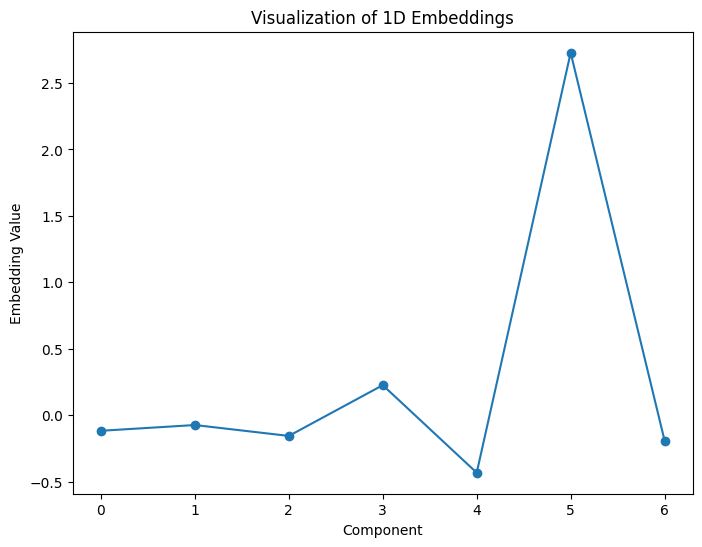

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming you have the 1D embeddings stored in the 'embeddings' variable

# Convert embeddings to a list
embeddings_list = embeddings.squeeze().tolist()

# Create x-axis indices
indices = list(range(len(embeddings_list)))

# Plot the 1D embeddings
plt.figure(figsize=(8, 6))
plt.plot(indices, embeddings_list, marker='o', linestyle='-')
plt.title('Visualization of 1D Embeddings')
plt.xlabel('Component')
plt.ylabel('Embedding Value')
plt.show()

In [ ]:
net2 = SiameseNetwork()
criterion2 = ContrastiveLoss()
optimizer2 = optim.Adam(net2.parameters(), lr=0.001)


In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(10, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )

    def forward_one(self, x):
        x = self.cnn_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Example usage
net2 = SiameseNetwork()
criterion2 = ContrastiveLoss()
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.001)



In [ ]:
train_siamese_network(dataloaders, net2, criterion2, optimizer2, epochs=1)